In [1]:
import sys
sys.path.insert(0, '/home/lshtanko/Programming/another-fem-framework/')
#sys.path.insert(0, '/Users/leonshting/Programming/Schlumberger/fem-framework/')

In [62]:
from common import helpers
from common.tests import partial_diff_test

from common import polynom_factory
import numpy as np
from itertools import product
from grid import cell, grid_layer, grid_manager
from grid.allocator_interface import InterfaceDofAllocator2D
from operator_assembler.n_to_1_ddof_allocator import Nto1Allocator2D
from operator import itemgetter
import itertools

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
sizes = [(0.,float(2**i)) for i in range(1)]

for size in sizes:
    mass_matrix = polynom_factory.local_funcfunc_matrix(order=3, dim=2, distribution='globatto', size=size)
    gradgrad = polynom_factory.local_gradgrad_matrix(order=3, distribution='globatto', dim=2, size=size)
    #gradfunc = polynom_factory.local_gradfunc_matrix(order=3, distribution='globatto', dim=2, size=size)[1][0]
    print(size)
    for (point,root) in gradgrad[1].items():
        print(point)
        partial_diff_test(matrix=gradgrad[0], point=point, pointnum=root, pointdict=gradgrad[1], mass_matrix=None)

In [3]:
cell1 = cell.Cell2D(size=(1,1), ll_vertex=(0,0))
cell2 = cell.Cell2D(size=(1,1), ll_vertex=(0,1))

cell3 = cell.Cell2D(size=(2,2), ll_vertex=(1,0))

In [4]:
layer1 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell1, cell2]], layer_number=0, index=[1,1], div_index=[1,1])
layer2 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell3]], layer_number=1, index=[1], div_index=[1])

In [5]:
gm = grid_manager.GridManager(dim=2, method='coarse2to1')

In [6]:
gm.grid_layers = [layer1, layer2]

In [7]:
ifma = InterfaceDofAllocator2D(grid_manager=gm)

In [8]:
ma = Nto1Allocator2D(grid_interface=ifma)
ma._make_ddof_index()

In [9]:
s2b = np.array([[ 1.22829849,  0.48464847, -0.25684608, -0.45610087],
       [ 0.23913821,  0.65966867,  0.1235421 , -0.02234897],
       [-0.1275535 ,  1.03266901,  0.15410032, -0.05921584],
       [-0.03430599,  1.34046152,  0.11031793, -0.41647347],
       [ 0.08818493, -0.06115703,  0.97521681, -0.00224471],
       [ 0.04581709, -0.324008  ,  0.58342807,  0.69476284],
       [-0.38762016,  0.29856527,  0.85477372,  0.23428118]])

b2s = np.array([[ 0.61414924,  0.59784553, -0.31888374, -0.03430599,  0.22046232,
         0.11454272, -0.19381008],
       [ 0.04846485,  0.32983433,  0.51633451,  0.2680923 , -0.03057852,
        -0.162004  ,  0.02985653],
       [-0.02568461,  0.06177105,  0.07705016,  0.02206359,  0.48760841,
         0.29171404,  0.08547737],
       [-0.22805044, -0.05587244, -0.14803959, -0.41647347, -0.00561177,
         1.73690711,  0.11714059]])

In [123]:
from scipy.sparse import coo_matrix,csr_matrix

In [34]:
gradgrad = polynom_factory.local_gradgrad_matrix(order=3, distribution='globatto', dim=2, size=(0,1))

In [113]:
def distributed_eye(pairtuples, shape):
    #print(pairtuples)
    d_loc = [d[0] for d in pairtuples]
    d_glob = [d[1] for d in pairtuples]
    return coo_matrix(([1] * len(pairtuples), (d_loc, d_glob)), shape=shape)

def distributed_eye_easy(pairtuples, shape_1):
    return distributed_eye(pairtuples=pairtuples, shape=(len(pairtuples), shape_1))

def stitch_how(host_neighbors, host_edge):
    pass
    
def ddofs_of_edge(host_neighbors, host_edge):
    ord_edges = ordered_edges(host_neighbors, host_edge)
    cnt = 0
    new_cnt = 0
    for num, (edge, props) in ord_edges:
        new_cnt += props[0] + 1 
        if(num == 0):
            return list(range(cnt, new_cnt))
        else:
            new_cnt -= 1
        cnt = new_cnt
        
def ordered_edges(host_neighbors, host_edge):
    host_neighbors.insert(0,host_edge)
    ordered_edges = sorted(enumerate(host_neighbors), key=lambda x: x[1][0][1][1])
    return (ordered_edges)

def order_peer(peers):
    return sorted(peers, key=lambda x: x[1][1][1])

def merge_two_cells(cell_1, cell_2):
    glob = csr_matrix((ma.ddof_cnt, ma.ddof_cnt))
    pairtup_1 = ma.get_cell_list_of_ddofs(cell=cell_1)
    props_1 = ma.get_cell_props(cell_1)
    pairtup_2 = ma.get_cell_list_of_ddofs(cell=cell_2)
    props_2 = ma.get_cell_props(cell_2)
    
    dist_1 = distributed_eye(pairtuples=pairtup_1, shape=(len(pairtup_1), ma.ddof_cnt))
    dist_2 = distributed_eye(pairtuples=pairtup_2, shape=(len(pairtup_2), ma.ddof_cnt))
    
    glob += dist_1.T * gradgrad[0] * dist_1
    glob += dist_2.T * gradgrad[0] * dist_2
    #plt.spy(glob)
    return glob

def distribute_one_cell(cell):
    glob = csr_matrix((ma.ddof_cnt, ma.ddof_cnt))
    pairtup_1 = ma.get_cell_list_of_ddofs(cell=cell)
    props_1 = ma.get_cell_props(cell)
    
    dist_1 = distributed_eye(pairtuples=pairtup_1, shape=(len(pairtup_1), ma.ddof_cnt))
    glob += dist_1.T * gradgrad[0] * dist_1
    return glob

In [122]:
joint_dofs_host

[37, 38, 39, 30]

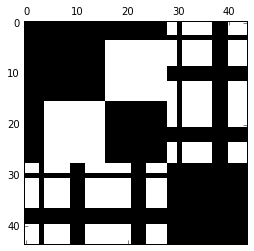

In [149]:
for num_l, cell in ma.grid_interface.iterate_cells_fbts(yield_layer_num=True):
    peers = ma.get_weakly_connected_edges(cell=cell)
    unique_edges = set([p[0] for p in peers])
    query_result = list(ma.grid_interface.query_adj_cells_by_edge(
        cell=cell,
        edge=peers[0][0],
        num_layer=num_l,
        size_rel_filter=['smaller', 'same']
    ).values())
    if(len(query_result) != 0):
        loc_glob = merge_two_cells(cell_1=query_result[0], cell_2=query_result[1])
        loc_glob_host = distribute_one_cell(cell=cell)
        joint_dofs = [[j[-1] for j in i[-1]] for i in order_peer(peers)]
        joint_dofs_fin = joint_dofs[0] + joint_dofs[1][1:]
        joint_dofs_host = [i[1] for i in ma._get_flat_list_of_ddofs(cell=cell, edge=peers[0][0])]
        joint_loc_dofs_host = [i[0] for i in ma._get_flat_list_of_ddofs(cell=cell, edge=peers[0][0])]
        
        trans_matrix_host_edge = distributed_eye_easy(
            pairtuples=ma._get_flat_list_of_ddofs(cell=cell, edge=peers[0][0]), shape_1=ma.ddof_cnt)
        
        trans_matrix_peer_edge = distributed_eye_easy(
            pairtuples=[(num, d) for num, d in enumerate(joint_dofs_fin)], shape_1=ma.ddof_cnt)
        
        tmp_peer = loc_glob[joint_dofs_fin]
        tmp_host = loc_glob_host[joint_dofs_host]
        transferred = (trans_matrix_host_edge.T * s2b.T * tmp_peer) + (trans_matrix_host_edge.T * s2b.T * tmp_peer).T
        transferred1 = (trans_matrix_peer_edge.T * b2s.T * tmp_host) + (trans_matrix_peer_edge.T * b2s.T * tmp_host).T
        
        
        plt.spy(transferred + transferred1 + loc_glob + loc_glob_host)